# Die ZEIT Zeitung API

Die ZEIT Zeitung stellt eine API zur Verfügung, durch die es möglich ist, auf Metadaten von Artikeln im Archiv der Zeitung zuzugreifen [http://developer.zeit.de/index/]. In diesem Projekt werden wir die Daten von diesem API extrahieren.

## Ziel des Projekts

Das Endziel des Projekts ist eine DataFrame zu erzeugen, das bereit zur Analyse ist. Es handelt sich also um ein Data Wrangling und Data Cleaning Projekt. 

Es besteht aus drei Phasen:

1) Die **ZEIT API**: durch die API auf Daten von mehreren Artikeln zugreifen

2) Durch **WebScrapping** die Anzahl der Kommentare finden, die jedes Artikel bekommen hat. 

3) Die Daten bereinigen, damit sie Analyse-bereit sind.


In [47]:
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

# API Erkunden

Der Products Endpoint bietet einen interessanten Ausgangspunkt an. Darin sind die Produkte der ZEIT AG aufgelistet.

In [48]:
headers = {"X-Authorization":"e8ebe23dc277cc2a3c903c18c35c9db3b049430e5ff1f6b33595"}

In [49]:
# Funktion, die Url abruft und Inhalt liest

def request_and_read(url,limit):
    # Verwandelt URL in Endpoint
    url = str(url)
    endpoint = r"{url}".format(url=url)
    
    # Ruft Inhalt ab
    r = requests.get(endpoint,
                    headers = headers, # Headers muss eine Variable im außen Umgebung sein
                    params = {"limit":limit}) 
    # Liest Inhalt
    content = json.loads(r.content)
    return content

In [50]:
erste_anfrage = request_and_read("http://api.zeit.de/product",10)

In [51]:
for d in erste_anfrage["matches"]:
    print("Product = {value}\nURL {href}\nURI {uri}\n".format(value = d["value"], href = d["href"], uri=d["uri"]))
    
print("Total = {}".format(erste_anfrage["found"]))

Product = ZEIT ONLINE
URL 
URI http://api.zeit.de/product/zede

Product = DIE ZEIT
URL 
URI http://api.zeit.de/product/zei

Product = Leserartikel
URL http://www.zeit.de/leserartikel/index
URI http://api.zeit.de/product/leserartikel

Product = ZEITmagazin
URL http://www.zeit.de/zeit-magazin/index
URI http://api.zeit.de/product/zmlb

Product = Test/Development
URL 
URI http://api.zeit.de/product/test

Product = ZEIT Campus
URL http://www.zeit.de/campus/index
URI http://api.zeit.de/product/ztcs

Product = ZEIT CAMPUS Ratgeber
URL http://www.zeit.de/campus/index
URI http://api.zeit.de/product/csrg

Product = ZEIT Wissen
URL http://www.zeit.de/wissen/zeit-wissen/index
URI http://api.zeit.de/product/ztwi

Product = ZEIT Geschichte
URL http://www.zeit.de/wissen/zeit-geschichte/index
URI http://api.zeit.de/product/ztgs

Product = Zeit Schweiz
URL 
URI http://api.zeit.de/product/zech

Total = 50


Die API bietet Zugang zu 50 unterschiedliche Produkte (nicht alle sind im oben stehenden Output gelistet). Dennoch nicht jedes Produkt ist zugreifbar durch die API.

Sie gehören anderen Medien, die Teil des ZEIT AG Konzerns sind oder sind nur für Abonnenten freigeschaltet.

## ZEITmagazin

Wenn man versucht Daten vom ZEITmagazin Endpoint abzurufen, erzeugt die Suche keine Ergebnisse.

In [52]:
magazin = request_and_read("http://api.zeit.de/product/zmlb",10)
magazin

{'matches': [],
 'uri': 'http://api.zeit.de/product/zmlb',
 'value': 'ZEITmagazin',
 'href': 'http://www.zeit.de/zeit-magazin/index',
 'limit': 10,
 'offset': 0,
 'found': 0,
 'id': 'zmlb'}

## ZEIT Online

Die Suchergebnisse sind anders, wenn man den ZEIT Online Endpoint stöbert.

In [53]:
zeit = request_and_read("http://api.zeit.de/product/zei",1)
zeit # Beinhaltet Daten von einem Artikel

{'matches': [{'subtitle': 'Therapeutinnenalltag, chinesische Philosophie und die Zukunft der Medizin: Auch in diesem Monat gibt es unter den zehn besten Sachbüchern interessante Neueinstiege.',
   'uuid': '2Dju1lzEsvnXHZMetnMOd6',
   'title': 'Die Sachbuch-Bestenliste für Mai',
   'href': 'http://www.zeit.de/2020/19/leseempfehlungen-sachbuch-bestenliste-mai',
   'release_date': '2020-04-28T16:42:52Z',
   'uri': 'http://api.zeit.de/content/2Dju1lzEsvnXHZMetnMOd6',
   'supertitle': 'Leseempfehlungen',
   'teaser_text': 'Therapeutinnenalltag, chinesische Philosophie und die Zukunft der Medizin: Auch in diesem Monat gibt es unter den zehn besten Sachbüchern interessante Neueinstiege.',
   'teaser_title': 'Die Sachbuch-Bestenliste für Mai'}],
 'uri': 'http://api.zeit.de/product/zei',
 'value': 'DIE ZEIT',
 'href': '',
 'limit': 1,
 'offset': 0,
 'found': 125423,
 'id': 'zei'}

# Gültige Endpoints

Da nicht jeder Endpunkt verfügbar ist (Zustand vom 28.04.2020), müssen wir herausfinden, welche Endpoints gültige Ergebnisse erzeugen und welche nicht. 

In [54]:
zweite_anfrage = request_and_read("http://api.zeit.de/product",50) # Neue Anfrage, um alle Ergebenisse abzurufen

endpoints = [] # Endpoints zu dieser Liste hinzufügen

for d in zweite_anfrage["matches"]: # Schleife durch die Items von "erste_anfrage"
    endpoints.append(d["uri"]) # Endpoints der Liste hinzufügen
    

# Ergbnisse nach Gültigkeit gruppieren
gueltige_endpoints = []
ungueltige_endpoints = []

for uri in endpoints:
    ergebnis =request_and_read(uri,1)
    if ergebnis["found"]== 0:
        ungueltige_endpoints.append(ergebnis["value"])
    elif ergebnis["found"]!= 0 or "0":
        print("\n",ergebnis["value"],ergebnis["found"], uri)
        gueltige_endpoints.append(ergebnis)
    



 ZEIT ONLINE 140422 http://api.zeit.de/product/zede

 DIE ZEIT 125423 http://api.zeit.de/product/zei

 DIE ZEIT 228443 http://api.zeit.de/product/zear


Oben ist es klar, dass von den 50 Endpoints nur drei eine gültige Suche ergeben. Wir werden nun die Suche auf diese Endpoints konzentrieren.

In [9]:
products = [x["value"] for x in gueltige_endpoints] # ist Comprehension, um Spalte mit Productnamen zu erstellen
found = [x["found"] for x in gueltige_endpoints] # List Comprehension, um Spalte mit Anzahl der Artikel zu erstellen

points = pd.DataFrame({"Endpoints":products,"N_Artikel":found}) # Instanziierung eines DataFrames

print("Gesamt Anzahl der Artikel = {}".format(points["N_Artikel"].sum()))

points["Anteil"] = points["N_Artikel"]/points["N_Artikel"].sum()
points

Gesamt Anzahl der Artikel = 494287


,Endpoints,N_Artikel,Anteil
0,ZEIT ONLINE,140421,0.284088
1,DIE ZEIT,125423,0.253745
2,DIE ZEIT,228443,0.462167


# Beschreibung der gültigen Endpoints

Die Endpoints unterscheiden sich untereinander durch die Ergebnisse, die sie zurückgeben.

## ZEIT ONLINE

Die Suchen ergeben höchstaktuelle Beiträge, die in digitalem Format veröffentlicht werden.

## Der erste DIE ZEIT Endpoint

Gibt Beiträge aus dem Archiv der Zeit ZEITUNG zurück. Diese Artikel wurden zwar auf die Webseite hochgelanden, aber scheinen ursprünglich für die ZEIT ZEITUNG geplant zu sein.

## Der zweite DIE ZEIT Endpoint

Dieser Endpoint zeigt Ergbenisse, die auf den ersten Blick aus dem Jahr 2018 oder früher stammen. Wenn man die Ergebnisse jedoch unter die Lupe nimmt, kommt man zu dem Schluss, dass sie eigentlich aus verschiedenen Jahren vor 2017 stammen. Sie gehören zu einem älteren Archiv der Zeit Zeitung, scheinen jedoch nicht nach Ausgabe der Zeitung oder nach Datum sortiert zu sein. 

In [10]:
points = [p["uri"] for p in gueltige_endpoints]
infos = {"release_date":[]}
for p in points:
    ergebnis = request_and_read(p,3)
    matches = ergebnis["matches"]
    value = ergebnis["value"]
    for m in matches:
        infos["release_date"].append((value,m["release_date"]))
    
count = 0
for tpl in infos["release_date"]:
    count +=1
    if count<3:
        print(tpl[0],tpl[1],"\n")
    elif 3<=count<=5:
        print(tpl[0],"(Erster Endpoint)", tpl[1],"\n")
    elif count>=5:
        print(tpl[0],"(Zweiter Endpoint)",tpl[1],"\n")
        

ZEIT ONLINE 2020-04-30T09:31:28Z 

ZEIT ONLINE 2020-04-30T09:29:02Z 

ZEIT ONLINE (Erster Endpoint) 2020-04-30T09:19:28Z 

DIE ZEIT (Erster Endpoint) 2020-04-28T16:42:52Z 

DIE ZEIT (Erster Endpoint) 2020-04-28T14:55:06Z 

DIE ZEIT (Zweiter Endpoint) 2020-04-28T14:55:02Z 

DIE ZEIT (Zweiter Endpoint) 2018-06-21T19:11:44Z 

DIE ZEIT (Zweiter Endpoint) 2018-06-21T03:06:54Z 

DIE ZEIT (Zweiter Endpoint) 2017-03-30T00:54:00Z 



Da die Endpoints unterschiedliche Zwecke erfüllen, werden wir sie zuerst in drei verschiedenen Datensätzen sammeln, um danach nach Belieben manipulieren und analysieren.  

# Artikel abrufen

Nun wissen wir, welche Endpoints gültige Ergbenisse bieten und welche nicht. Dies ermöglich Artikel effizient abzurufen.

# Die ZEIT ONLINE Endpoint

Anfrage machen durch die request_and_read Funktion

In [55]:
zeit_online_anfrage = request_and_read("http://api.zeit.de/product/zede",1000) # Anfrage an die Zeit ONLINE Endpoint

Die request_and_read Funktion gibt eine Dictionary zurück, die von der metadata_auspacken()Fuktion angenommen werden kann.

In [56]:
print(type(zeit_online_anfrage))

<class 'dict'>


In [57]:
# Funktion, um Daten von den Artikeln abzurufen

def get_metadata(big_dictionary): # Die Funktion nimmt die Dictionary aus der request_and_read Funktion an
    
    list_of_dictionaries = big_dictionary["matches"] # Sie greift auf die Schlüssel "matches" in Dictionary zu
    
    # Instaziierung einer Dictionary, um die gültigen Werte zu empfangen
    valid = {"subtitle": [], "uuid": [],"title": [],"href":[],
         "release_date":[],"uri":[],"supertitle": [],"teaser_text":[],"teaser_title":[]}
    
    for d in list_of_dictionaries: # Vergleicht die Keys von Endpoint(list of dictionaries) mit dem Keys von Valid
        
        if d.keys() == valid.keys(): # Wenn Keys übereinstimmen, setzt Auspackung der Daten fort
            valid["subtitle"].append(d["subtitle"])
            valid["uuid"].append(d["uuid"])
            valid["title"].append(d["title"])
            valid["href"].append(d["href"])
            valid["release_date"].append(d["release_date"])
            valid["uri"].append(d["uri"])
            valid["supertitle"].append(d["supertitle"])
            valid["teaser_text"].append(d["teaser_text"])
            valid["teaser_title"].append(d["teaser_title"])
            
        else: # Wenn Keys nicht übereinstimmen, überspringt diesen Eintrag
            continue
            
    # Dieser Ansatz ist wichtig, um die Sammlung von fehlenden oder defekten Daten zu vermeiden
    # Mit früheren Versionen diese Funktion hatte ich oft unerwartete Abstürze
    # bei dem Auftritt eines Eintrags, der von der Regel abweicht. 
            
    return  valid


    

In [58]:
zeit_online_dict = get_metadata(zeit_online_anfrage)

### Prüft Erfolg der ersten Datensammlung

In [59]:
for key in zeit_online_dict:
    print(len(zeit_online_dict[key]))

# 100 Eintröge wurden gestöbert, dennoch nur 99 haben gültige Ergebnisse erzeugt

999
999
999
999
999
999
999
999
999


In [60]:
zeit_online_dict["uri"]

['http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy',
 'http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH',
 'http://api.zeit.de/content/17nX20sqog0syzcqokBmch',
 'http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5',
 'http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa',
 'http://api.zeit.de/content/4RXS5nVJ5gR1qpxnBuHxuL',
 'http://api.zeit.de/content/4eIAiYMDNi3lBrVWHrRK7V',
 'http://api.zeit.de/content/6hFUR6VMA7X4RITQ8DkXNI',
 'http://api.zeit.de/content/11srRd1LScPPDtXzoo8bQF',
 'http://api.zeit.de/content/4iBboaOYYLd2QIHT6cMkxo',
 'http://api.zeit.de/content/gMeSDGyVN6GFHpOQoZzIy',
 'http://api.zeit.de/content/4q7yCfSbcqWYBks9Vf0cXK',
 'http://api.zeit.de/content/3J62hB2wzRq1aXwSAeRhgI',
 'http://api.zeit.de/content/3iXZXvVYZBwZacyImCg7f2',
 'http://api.zeit.de/content/3FugDz8TcYTG1vHH2sEQGJ',
 'http://api.zeit.de/content/3vcDJGW9qFlnfjfUZELOj1',
 'http://api.zeit.de/content/5VkrFSWWoeAfU8bQPeeHpQ',
 'http://api.zeit.de/content/4ULQHB6g6sBonaUwJvvPHE',
 'http://api.zeit.de/content/

## Weitere Daten erheben

Die get_metadata() Funktion gibt eine Dictionary zurück. Eine von den Schlüsseln dieser Dictionary heißt "uri". Die Uris sind ein einzigartiger Bezeichner der Artikel von dem entsprechenden Endpoint. Anhand der Uri ist es möglich noch weitere Daten abzurufen.

In [61]:
zeit_online_dict["uri"][:5]

['http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy',
 'http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH',
 'http://api.zeit.de/content/17nX20sqog0syzcqokBmch',
 'http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5',
 'http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa']

In [62]:
daten = request_and_read(zeit_online_dict["uri"][0],10)
daten

{'teaser_title': 'BGH trifft im Sampling-Streit keine Entscheidung',
 'uuid': '3N3Y8Phbo0SoP6x3cFxJFy',
 'title': 'BGH trifft im Sampling-Streit keine Entscheidung',
 'release_date': '2020-04-30T09:52:34Z',
 'uri': 'http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy',
 'relations': [],
 'supertitle': 'Urheberschutz',
 'href': 'http://www.zeit.de/kultur/musik/2020-04/urheberschutz-kraftwerk-pelham-zwei-sekunden-beat-bgh-urteil',
 'teaser_text': 'Der Rechtsstreit zwischen Musikproduzent Moses Pelham und Kraftwerk geht erneut an das Oberlandesgericht Hamburg. Der BGH positionierte sich jedoch – im Sinne Pelhams.',
 'keywords': [{'uri': 'http://api.zeit.de/keyword/moses-pelham',
   'rel': 'person',
   'name': 'Moses Pelham'},
  {'uri': 'http://api.zeit.de/keyword/sabrina-setlur',
   'rel': 'person',
   'name': 'Sabrina Setlur'},
  {'uri': 'http://api.zeit.de/keyword/kraftwerk',
   'rel': 'subject',
   'name': 'Kraftwerk'},
  {'uri': 'http://api.zeit.de/keyword/bundesverfassungsgericht',
   

In [63]:
def get_daten(l):
    daten = {'teaser_title':[],'uuid':[],'title':[],
             'release_date':[],'uri':[],'relations':[], 
             'supertitle':[], 'href':[], 'teaser_text':[], 
             'keywords':[], 'creators':[], 'categories':[]} # Dictionary, die die Daten empfängt
    for uri in l:
        info = request_and_read(str(uri),10) # Stellt Anfrage und liest request (info ist eine Dictionary)
        
#         if info.keys()==daten.keys(): # Vergleicht Keys, um Sammlung fehlender Daten zu vermeiden
            
            # Jede Key in Info enthält eine Liste mit einem oder mehreren Werten
            
            # Wenn Keys übereinstimmen, fügt die Daten der Daten Dictionary hinzu
        daten["uri"].append(info["uri"])
    
        for word in info["keywords"]: #stöbert die Schlüssel von Keywords dictionary
                                            # Muss For Schleife sein, weil manche Artikel mehrere Keywords enthalten
            
            daten["keywords"].append((str(uri),word["name"])) 
                # fügt die Schlüssel Wörter der Daten Dictionary hinzu
                # Neben dem erwünschten Wert wird auch die URI der Daten Ditionary hinzugefügt
                # Dies ist wichtig für die Überprüfung, ob alles richtig läuft
        
    
        for creator in info["creators"]: # Widerholt das Verfahren mit creator Dictionary
            daten["creators"].append((str(uri),creator["name"]))
        
    
        for c in info["categories"]: # Noch einmal dasselbe für die categories
            daten["categories"].append((str(uri),c["name"]))
        
        
    return daten # Manche Schlüssel bleiben leer, da sie nur der Überprüfung von Datenintegrität dienen
        

In [64]:
zeit_online_daten  = get_daten(zeit_online_dict["uri"])

In [65]:
zeit_online_daten

{'teaser_title': [],
 'uuid': [],
 'title': [],
 'release_date': [],
 'uri': ['http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy',
  'http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH',
  'http://api.zeit.de/content/17nX20sqog0syzcqokBmch',
  'http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5',
  'http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa',
  'http://api.zeit.de/content/4RXS5nVJ5gR1qpxnBuHxuL',
  'http://api.zeit.de/content/4eIAiYMDNi3lBrVWHrRK7V',
  'http://api.zeit.de/content/6hFUR6VMA7X4RITQ8DkXNI',
  'http://api.zeit.de/content/11srRd1LScPPDtXzoo8bQF',
  'http://api.zeit.de/content/4iBboaOYYLd2QIHT6cMkxo',
  'http://api.zeit.de/content/gMeSDGyVN6GFHpOQoZzIy',
  'http://api.zeit.de/content/4q7yCfSbcqWYBks9Vf0cXK',
  'http://api.zeit.de/content/3J62hB2wzRq1aXwSAeRhgI',
  'http://api.zeit.de/content/3iXZXvVYZBwZacyImCg7f2',
  'http://api.zeit.de/content/3FugDz8TcYTG1vHH2sEQGJ',
  'http://api.zeit.de/content/3vcDJGW9qFlnfjfUZELOj1',
  'http://api.zeit.de/content/5VkrFSWWoeAfU8b

### Prüft Erfolg der zweiten Daten Sammlung

In [66]:
for key in zeit_online_daten:
    print(key," ",len(zeit_online_daten[key]))

teaser_title   0
uuid   0
title   0
release_date   0
uri   999
relations   0
supertitle   0
href   0
teaser_text   0
keywords   3957
creators   1098
categories   1051


In [67]:
zeit_online_daten["keywords"]

[('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Moses Pelham'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Sabrina Setlur'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Kraftwerk'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy',
  'Bundesverfassungsgericht'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Bundesgerichtshof'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Metall'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Hisbollah'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Terrorismus'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Bundesregierung'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Horst Seehofer'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Antisemitismus'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Israel'),
 ('http://api.zeit.de/content/17nX20sqog0syzcqokBmch', 'Joe Biden'),
 ('http://api.zeit.de/content/17nX20sqog0syzcqokBmch', 'US

## Daten Ordnen

Jetzt, dass die Daten heruntergeladen wurden, können sie in ein Format umwandelt werden, das den Umgang mit den Daten erleichtert.

## Umwandlung der Dictionary mit Metadaten

Der einfachste Weg die Dictionary in ein DataFrame zu konvertieren wäre mithilfe einer Instaziierung. Dies ist jedoch nur möglich, wenn die Listen in den Schlüsseln von zeit_online_dict gleich lang sind.

In [176]:
zeit_online_df = pd.DataFrame(zeit_online_dict)

In [177]:
zeit_online_df

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title
0,Der Rechtsstreit zwischen Musikproduzent Moses...,3N3Y8Phbo0SoP6x3cFxJFy,BGH trifft im Sampling-Streit keine Entscheidung,http://www.zeit.de/kultur/musik/2020-04/urhebe...,2020-04-30T09:52:34Z,http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy,Urheberschutz,Der Rechtsstreit zwischen Musikproduzent Moses...,BGH trifft im Sampling-Streit keine Entscheidung
1,Die Regierung Israels und der Zentralrat der J...,4tYdQ9hhtpsEiD7IOEHiDH,"Israel lobt deutsches Hisbollah-Verbot als ""be...",http://www.zeit.de/politik/deutschland/2020-04...,2020-04-30T09:43:22Z,http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH,Hisbollah-Verbot,Die Regierung Israels und der Zentralrat der J...,"Israel lobt deutsches Hisbollah-Verbot als ""be..."
2,Während Donald Trump das Weiße Haus als Bühne ...,17nX20sqog0syzcqokBmch,Joe Bidens #MeToo-Problem,http://www.zeit.de/politik/ausland/2020-04/joe...,2020-04-30T09:31:28Z,http://api.zeit.de/content/17nX20sqog0syzcqokBmch,US-Wahl,Während Donald Trump das Weiße Haus als Bühne ...,Joe Bidens #MeToo-Problem
3,Wird es Hilfen für die Gastronomie und Lockeru...,1zCFg4Bkch3jUxU0B35Ch5,Kontaktbeschränkungen sollen bis 10. Mai verlä...,http://www.zeit.de/politik/deutschland/2020-04...,2020-04-30T09:29:02Z,http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5,Corona-Einschränkungen,Wird es Hilfen für die Gastronomie und Lockeru...,Kontaktbeschränkungen sollen bis 10. Mai verlä...
4,"Wenn schon ""Zimmer mit Aussicht"", dann soll es...",1sIGbdo58U5EMnJKGIaYQa,Die besten Alben gegen das Virus,http://www.zeit.de/kultur/musik/2020-04/neue-a...,2020-04-30T09:19:28Z,http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa,Neue Alben 2020,"Wenn schon ""Zimmer mit Aussicht"", dann soll es...",Die besten Alben gegen das Virus
...,...,...,...,...,...,...,...,...,...
994,Hier haben wir recherchiert. Dies sind die zen...,3QbVS5AToQsBxYIsqwBDrK,Unsere Quellen,http://www.zeit.de/wq/2020-16,2020-04-07T14:50:03Z,http://api.zeit.de/content/3QbVS5AToQsBxYIsqwBDrK,Ausgabe 16/2020,Hier haben wir recherchiert. Dies sind die zen...,Unsere Quellen
995,"Die Bundesbildungsministerin kündigt an, zwölf...",5raMxSgHdxKc2SJFoNYFgA,Bundesregierung will Antisemitismusforschung s...,http://www.zeit.de/politik/deutschland/2020-04...,2020-04-07T14:38:59Z,http://api.zeit.de/content/5raMxSgHdxKc2SJFoNYFgA,Förderprogramm,"Die Bundesbildungsministerin kündigt an, zwölf...",Bundesregierung will Antisemitismusforschung s...
996,Der Prozess um das Unglück bei der Loveparade ...,3x6lF6n2WSZBII6wx0F8vh,Landgericht schlägt Einstellung von Loveparade...,http://www.zeit.de/gesellschaft/zeitgeschehen/...,2020-04-07T13:44:42Z,http://api.zeit.de/content/3x6lF6n2WSZBII6wx0F8vh,Duisburg,Wegen der Corona-Pandemie ist dem Gericht zufo...,Landgericht schlägt Einstellung von Loveparade...
997,Jeden Freitag empfehlen wir im neuen Wochenmar...,7nx6uYrWwvMbwteiRQv72x,Abonnieren Sie jetzt unseren Wochenmarkt-Newsl...,http://www.zeit.de/wochenmarkt-newsletter,2020-04-07T13:39:20Z,http://api.zeit.de/content/7nx6uYrWwvMbwteiRQv72x,Mein Z+,Jeden Freitag empfehlen wir im neuen Wochenmar...,Abonnieren Sie jetzt unseren Wochenmarkt-Newsl...


## Umwandlung der Dictionary mit Daten

Um uns zu versichern, dass wir wissen, welche Daten zu welchem Artikel gehören, haben wir bei der zweiten Datensammlung neben dem erwünschten Daten die URI hinzugefügt. Das Ergebnis sieht so aus:

In [70]:
# Mehrehre Keywords werden von demselben uri begleitet.
zeit_online_daten["keywords"][:10]

[('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Moses Pelham'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Sabrina Setlur'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Kraftwerk'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy',
  'Bundesverfassungsgericht'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Bundesgerichtshof'),
 ('http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy', 'Metall'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Hisbollah'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Terrorismus'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Bundesregierung'),
 ('http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH', 'Horst Seehofer')]

Wir müssen nun sie in ein Format umwandeln, das mit dem Hauptdataframe kompatibel ist.

In [173]:
# Funktion, um die Werten von der Daten Dictionary zu organisieren
def organize(l):
    end_values = [] # Schafft eine Liste
    
    df = pd.DataFrame(l) 
    # Konvertiert L (ursprünglicher Wert aus der Dictionary) in DataFrame
    # Bei der Konversion wird ein DataFrame mit den Spalten 0 für die uris und 1 für die Keywords geschafft
    
    for uri in df[0].unique(): # Schleift durch die Uri
        group = df.loc[df[0]==uri,1] # Gruppiert die Werten nach uri und wählt Keyword Spalte aus
        wanted_values = group.values # Extrahiert die entsprechenden Keywords
        end_values.append([uri,wanted_values]) # Fügt Werte der end_values Liste hinzu
        
    end_values = pd.DataFrame(end_values) # konvertiert die Liste in Series
    return end_values # Das Ergebnis kann dem Hauptdataframe hinzugefügt werden


In [185]:
keywords = organize(zeit_online_daten["keywords"])
autors = organize(zeit_online_daten["creators"])
products = organize(zeit_online_daten["categories"])                     

Showing Output

In [189]:
# Output is a DataFrame
# Die Namen der Spalten müssen jedoch noch umbenannt werden, um die Zusammenfügung der DataFrames zu ermöglichen
keywords

,uri,keywords
0,http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy,"[Moses Pelham, Sabrina Setlur, Kraftwerk, Bund..."
1,http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH,"[Hisbollah, Terrorismus, Bundesregierung, Hors..."
2,http://api.zeit.de/content/17nX20sqog0syzcqokBmch,"[Joe Biden, USA, US-Wahl, Donald Trump]"
3,http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5,"[Angela Merkel, Bundesregierung]"
4,http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa,"[Musik, Popmusik, Hip-Hop, Elektronische Musik..."
...,...,...
980,http://api.zeit.de/content/3QbVS5AToQsBxYIsqwBDrK,"[Bonn, Heinsberg]"
981,http://api.zeit.de/content/5raMxSgHdxKc2SJFoNYFgA,"[Berlin, Darmstadt, Dortmund, Bundesregierung,..."
982,http://api.zeit.de/content/3x6lF6n2WSZBII6wx0F8vh,"[Duisburg, Nordrhein-Westfalen, Loveparade, La..."
983,http://api.zeit.de/content/7nx6uYrWwvMbwteiRQv72x,[Kochen]


In [191]:
autors.rename({0:"uri",1:"autors"}, axis = 1, inplace = True)
products.rename({0:"uri",1:"products"},axis = 1, inplace = True)

In [196]:
zeit_online_df = zeit_online_df.merge(keywords, on="uri",how="inner")
zeit_online_df = zeit_online_df.merge(autors,on = "uri", how = "inner")
zeit_online_df = zeit_online_df.merge(products, on = "uri", how = "inner")

Der Datensatz sieht nun wie folgend aus:

In [197]:
zeit_online_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,autors,products,keywords
0,Der Rechtsstreit zwischen Musikproduzent Moses...,3N3Y8Phbo0SoP6x3cFxJFy,BGH trifft im Sampling-Streit keine Entscheidung,http://www.zeit.de/kultur/musik/2020-04/urhebe...,2020-04-30T09:52:34Z,http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy,Urheberschutz,Der Rechtsstreit zwischen Musikproduzent Moses...,BGH trifft im Sampling-Streit keine Entscheidung,[Sybille Klormann],[ZEIT ONLINE],"[Moses Pelham, Sabrina Setlur, Kraftwerk, Bund..."
1,Die Regierung Israels und der Zentralrat der J...,4tYdQ9hhtpsEiD7IOEHiDH,"Israel lobt deutsches Hisbollah-Verbot als ""be...",http://www.zeit.de/politik/deutschland/2020-04...,2020-04-30T09:43:22Z,http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH,Hisbollah-Verbot,Die Regierung Israels und der Zentralrat der J...,"Israel lobt deutsches Hisbollah-Verbot als ""be...",[Katharina Heflik],[ZEIT ONLINE],"[Hisbollah, Terrorismus, Bundesregierung, Hors..."
2,Während Donald Trump das Weiße Haus als Bühne ...,17nX20sqog0syzcqokBmch,Joe Bidens #MeToo-Problem,http://www.zeit.de/politik/ausland/2020-04/joe...,2020-04-30T09:31:28Z,http://api.zeit.de/content/17nX20sqog0syzcqokBmch,US-Wahl,Während Donald Trump das Weiße Haus als Bühne ...,Joe Bidens #MeToo-Problem,"[Rieke Havertz, Klaus Brinkbäumer]",[ZEIT ONLINE],"[Joe Biden, USA, US-Wahl, Donald Trump]"
3,Wird es Hilfen für die Gastronomie und Lockeru...,1zCFg4Bkch3jUxU0B35Ch5,Kontaktbeschränkungen sollen bis 10. Mai verlä...,http://www.zeit.de/politik/deutschland/2020-04...,2020-04-30T09:29:02Z,http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5,Corona-Einschränkungen,Wird es Hilfen für die Gastronomie und Lockeru...,Kontaktbeschränkungen sollen bis 10. Mai verlä...,[Sybille Klormann],[ZEIT ONLINE],"[Angela Merkel, Bundesregierung]"
4,"Wenn schon ""Zimmer mit Aussicht"", dann soll es...",1sIGbdo58U5EMnJKGIaYQa,Die besten Alben gegen das Virus,http://www.zeit.de/kultur/musik/2020-04/neue-a...,2020-04-30T09:19:28Z,http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa,Neue Alben 2020,"Wenn schon ""Zimmer mit Aussicht"", dann soll es...",Die besten Alben gegen das Virus,"[Jens Balzer, Martin Eimermacher, Daniel Gerha...",[ZEIT ONLINE],"[Musik, Popmusik, Hip-Hop, Elektronische Musik..."


# Web Scrapping

Neben den schon erhobenen Daten ist es anhand von Web Scrapping möglich weitere Daten zu sammeln, insbesondere die Anzahl von Kommentaren eines Artikels. Nachdem die Daten geordnet wurden ist die Liste von urls in der href Spalte der oben stehenden DataFrame.

In [75]:
# Vorschau der gesammelten urls

zeit_online_df["href"].head()

0    http://www.zeit.de/kultur/musik/2020-04/urhebe...
1    http://www.zeit.de/politik/deutschland/2020-04...
2    http://www.zeit.de/politik/ausland/2020-04/joe...
3    http://www.zeit.de/politik/deutschland/2020-04...
4    http://www.zeit.de/kultur/musik/2020-04/neue-a...
Name: href, dtype: object

Die Anzahl der Kommentare sind sowohl im Header angegeben, als auch in der Kommentare Section. Jedoch die Anzal der Kommentare von der Comments Section abzurufen ist sicher, denn sie wird nicht im Header gezeigt, wenn der Artikel noch nicht kommentiert wurde. 

## Kommentare aus HTML Extrahieren

In [76]:
# Optimierte Version von find_comments

def new_find_comments(Series):
    kommentare = {"href":[],
                 "Kommentare_Anzahl":[]}
    for url in Series:
        
        try:
            html = requests.get(str(url))
            content = BeautifulSoup(html.content,"html.parser")
            comment = content.find(class_="comment-section__headline")
        
        # Manche Suche ergeben ein List objekt, manche ein String objekt
        # Um Fehler zu vermeiden, gibt die Funktion nicht die genaue Anzahl der Kommentare zurück
        # Auf eine weitere Bereinigung der Daten ist hingewiesen
        
        except:
            print("Ein Fehler ist bei folgender URI aufgetreten: {}".format(url))
            comment = "Nicht gefunden"
    
        kommentare["href"].append(url)
        kommentare["Kommentare_Anzahl"].append(comment)
    
    kommentare = pd.DataFrame(kommentare)                                           
    
    return kommentare

# Diese Funktion kann NOCH OPTIMIERT WERDEN, um die Anzahl der Kommentare innerhalb der Funktion zu bereinigen
# Die Anzahl der Fehlermeldungen ist angestigen nach den getätigten Änderungsversuchen, so dass
# die einfache Version der Funktion ist beibehalten und somit ein weiteer Databereinigung Schritt nötig ist

In [77]:
kommentare_zeit_online = new_find_comments(zeit_online_df["href"])

Die new_find_comments() Funktion gibt das ganze "Class" des HTMls Objekts zurück. Diese Daten können dem DataFrame auf zwei Weise hinzugefügt werden:

1) Direkt durch die Anwendung der pd.apply() Methode auf die artikel_df["href"] Series und die Erstellung einer neuen Spalte.

2) Indirekt mithilfe einer DataFrame, welches die Anzahl der Kommentare samt der URI zwischenspeichert.

Da die Ergebnisse der Funktion (noch) weiter bereinigt werden müssen, werden wir den zweiten Weg bevorzugen, denn er stellt sich als eine "stabilere" Lösung dar (um die Daten in der Dictionary zu bereinigen, muss man nicht das ganze DataFrame manipulieren). 

In [78]:
# Vorschau des unreinigten DataFrame
kommentare_zeit_online.head()

,href,Kommentare_Anzahl
0,http://www.zeit.de/kultur/musik/2020-04/urhebe...,[\n 3 Kommentare\n ...
1,http://www.zeit.de/politik/deutschland/2020-04...,[\n 0 Kommentare\n ...
2,http://www.zeit.de/politik/ausland/2020-04/joe...,[\n 9 Kommentare\n ...
3,http://www.zeit.de/politik/deutschland/2020-04...,[\n 9 Kommentare\n ...
4,http://www.zeit.de/kultur/musik/2020-04/neue-a...,None


### Weitere Datenbereinigung

In [79]:
# Databereinigung
kommentare_zeit_online["Kommentare_Anzahl"] = kommentare_zeit_online["Kommentare_Anzahl"].astype(str) 
# Konvertiert von Bs4 Objekt zum string

kommentare_zeit_online["Kommentare_Anzahl"] = kommentare_zeit_online["Kommentare_Anzahl"].str.extract(r"([\d]+)")
# Benutzt Pandas string methods, um anhand einer REGEX die Anzahl der Kommentare zu extrahieren

## Dataverlust Prüfen

In [80]:
# Endergebnis
# kommentare.rename({"url":"href"}, axis = 1, inplace = True)
total = kommentare_zeit_online["Kommentare_Anzahl"].shape[0]
missing = kommentare_zeit_online["Kommentare_Anzahl"].isnull().sum()
print("Von {} Einträgen fehlen {}.\nDas beträgt einen Anteil von {}%".format(total, missing, (missing/total)))

Von 999 Einträgen fehlen 89.
Das beträgt einen Anteil von 0.0890890890890891%


### Kommentare zu dem HauptDataFrame hinzufügen

In diesem Moment es ist möglich die Anzahl der Kommentare zu dem DataFrame mit den anderen Daten des Artikels hinzuzufügen.

In [199]:
zeit_online_df = zeit_online_df.merge(right = kommentare_zeit_online,on="href", how = "inner")

## Prüfung nach fehlenden Daten im gesamten DataFrame

In [200]:
zeit_online_df.isnull().sum()

subtitle              0
uuid                  0
title                 0
href                  0
release_date          0
uri                   0
supertitle            0
teaser_text           0
teaser_title          0
autors                0
products              0
keywords              0
Kommentare_Anzahl    80
dtype: int64

## Vorschau der ZEIT ONLINE DataFrame

In [201]:
zeit_online = zeit_online_df.copy()
zeit_online.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,autors,products,keywords,Kommentare_Anzahl
0,Der Rechtsstreit zwischen Musikproduzent Moses...,3N3Y8Phbo0SoP6x3cFxJFy,BGH trifft im Sampling-Streit keine Entscheidung,http://www.zeit.de/kultur/musik/2020-04/urhebe...,2020-04-30T09:52:34Z,http://api.zeit.de/content/3N3Y8Phbo0SoP6x3cFxJFy,Urheberschutz,Der Rechtsstreit zwischen Musikproduzent Moses...,BGH trifft im Sampling-Streit keine Entscheidung,[Sybille Klormann],[ZEIT ONLINE],"[Moses Pelham, Sabrina Setlur, Kraftwerk, Bund...",3
1,Die Regierung Israels und der Zentralrat der J...,4tYdQ9hhtpsEiD7IOEHiDH,"Israel lobt deutsches Hisbollah-Verbot als ""be...",http://www.zeit.de/politik/deutschland/2020-04...,2020-04-30T09:43:22Z,http://api.zeit.de/content/4tYdQ9hhtpsEiD7IOEHiDH,Hisbollah-Verbot,Die Regierung Israels und der Zentralrat der J...,"Israel lobt deutsches Hisbollah-Verbot als ""be...",[Katharina Heflik],[ZEIT ONLINE],"[Hisbollah, Terrorismus, Bundesregierung, Hors...",0
2,Während Donald Trump das Weiße Haus als Bühne ...,17nX20sqog0syzcqokBmch,Joe Bidens #MeToo-Problem,http://www.zeit.de/politik/ausland/2020-04/joe...,2020-04-30T09:31:28Z,http://api.zeit.de/content/17nX20sqog0syzcqokBmch,US-Wahl,Während Donald Trump das Weiße Haus als Bühne ...,Joe Bidens #MeToo-Problem,"[Rieke Havertz, Klaus Brinkbäumer]",[ZEIT ONLINE],"[Joe Biden, USA, US-Wahl, Donald Trump]",9
3,Wird es Hilfen für die Gastronomie und Lockeru...,1zCFg4Bkch3jUxU0B35Ch5,Kontaktbeschränkungen sollen bis 10. Mai verlä...,http://www.zeit.de/politik/deutschland/2020-04...,2020-04-30T09:29:02Z,http://api.zeit.de/content/1zCFg4Bkch3jUxU0B35Ch5,Corona-Einschränkungen,Wird es Hilfen für die Gastronomie und Lockeru...,Kontaktbeschränkungen sollen bis 10. Mai verlä...,[Sybille Klormann],[ZEIT ONLINE],"[Angela Merkel, Bundesregierung]",9
4,"Wenn schon ""Zimmer mit Aussicht"", dann soll es...",1sIGbdo58U5EMnJKGIaYQa,Die besten Alben gegen das Virus,http://www.zeit.de/kultur/musik/2020-04/neue-a...,2020-04-30T09:19:28Z,http://api.zeit.de/content/1sIGbdo58U5EMnJKGIaYQa,Neue Alben 2020,"Wenn schon ""Zimmer mit Aussicht"", dann soll es...",Die besten Alben gegen das Virus,"[Jens Balzer, Martin Eimermacher, Daniel Gerha...",[ZEIT ONLINE],"[Musik, Popmusik, Hip-Hop, Elektronische Musik...",NaN


# File Speichern

In [202]:
zeit_online.to_csv(r"C:\Users\celio\My Projects\Guided Projects\Bewerbung\zeit_online.csv")

# Zusammenfassung des Verfahrens

1) **Einfache Anfrage erstellen:**
    
    - request_and_read(endpoint,limit)
    
    - Output = Dictionary mit metadatan zu n-Artikel aus dem Endpoint
    
2) **Metadata auspacken**

    - metadata_auspacken(dictionary) - extrahiert die Metadata und organisiert sie in einer anderen Dictionary
    
    - Output = Dictionary (bereit zur Konversion in DataFrame)
    
3) **Prüfen, on Daten richtig extrahiert wurden**

4) **Daten auspacken (in der entstandenen dictionary besteht eine Schlüssel, die uris enthält. Durch die uris kann man auf weitere Daten zugreifen).**

    - data_auspacken(list) - nimmt eine Liste an, weil der Schlüssels Wert eine Liste ist.
    
    - Output - eine Dictionary mit Listen (jede Schlüssel enthält die Keyword und die entsprechende uri)

5) **Daten organisieren (jedes Objekt in der Dictionary von daten_auspacken mit dem uri verbunden, dieses Format ist noch nicht bereit zur Beifügung zum DataFrame).**

    - organize(list): gruppiert die Werte der Liste nach uri
    
    - Output: organized DataFrame
    
6) **Join DataFrame (Zwei DataFrames sind entstanden. Man kann sie zusammenfügen mit merge)**

7) **Web Scrapping (das DataFrame enthält eine Spalte mit uris. Anhand dieser Einträge kann man weitere Daten sammeln.**

    - new_find_commments(url): nimmt eine url, greift auf die Adresse zu und findet die Anzahl der Kommentare
    
    - Output: DataFrame, deren Daten noch bereignit werden müssen
    
8) **Data Cleaning (manuell die Objekte in der Series zum String type konvertieren und die Anzahl von Kommentaren anhand einer REGEX finden und extrahieren)**

9) **Datenverlust prüfen**

10) **DataFrame mit Kommentaren zum HauptDataFrame hinzufügen**

# Der erste DIE ZEIT Endpoint

Nach der Datenerhebung bei dem ZEIT ONLINE Endpoint dürfen wir weiter machen und das gesamte Verfahren für den ersten DIE ZEIT Endpoint wiederholen. 

## Anfrage stellen

In [85]:
erste_zeit_anfrage = request_and_read("http://api.zeit.de/product/zei",1000)

In [86]:
# Funktioniert wie metadata_auspacken, aber handelt Fehler besser

def test_metadata_auspacken(d): # Funktion, um die Json Datei zu lesen und wichtige Informationenauszupacken
    l = d["matches"] # Erste Dictionary zugreifen
    # Dictionary um die Daten zu empfangen
    metadata = {"title":[],
               "href":[],
               "subtitle":[],
               "release_date":[],
               "supertitle":[],
               "uri":[]}
    # Schleife durch die Elementen von Json dictionary
    # Dabei Daten der Metadata Dictionary hinzufügen
    
    for element in l:
        try:
            metadata["title"].append(element["title"])
            metadata["href"].append(element["href"])
            metadata["subtitle"].append(element["subtitle"])
            metadata["release_date"].append(element["release_date"])
            metadata["supertitle"].append(element["supertitle"])
            metadata["uri"].append(element["uri"])
        
        except KeyError:
            pass
    
    # Metadata Dictionary zurückgeben
    return metadata

## Metadaten Auspacken

Leider funktioniert die Strategie, die bei der Zeit ONLINE Endpoint funktioniert hat, hier nicht. Aus diesem Grund müssen wir einen Umweg finden, die erhobenen Daten in ein DataFrame zu konvertieren

In [94]:
# erste_zeit = pd.DataFrame(test_metadata_auspacken(erste_zeit_anfrage))
erste_zeit_dict = get_metadata(erste_zeit_anfrage)

In [95]:
erste_zeit_dict["uri"][:10]

['http://api.zeit.de/content/2Dju1lzEsvnXHZMetnMOd6',
 'http://api.zeit.de/content/1WK8o8sFqzzpUlIJxL0t9w',
 'http://api.zeit.de/content/1jyjQTvJ3h4MQmJHzFEiXb',
 'http://api.zeit.de/content/ngyq6upeVkm4te78dCVSR',
 'http://api.zeit.de/content/3DwTT04coRkRzESQqK0vnP',
 'http://api.zeit.de/content/5bGXpNftdMiqQyLJCTbtD7',
 'http://api.zeit.de/content/5WXpD3Lh9cZO8zz7os8xO2',
 'http://api.zeit.de/content/51qw7zLRHrbPRcLShE3JXP',
 'http://api.zeit.de/content/4JMX8jG0CW9OdJsUAjOq0T',
 'http://api.zeit.de/content/XvheIMa4Cz8TQYx5cXRtt']

## Prüfung der ersten Datensammlung

In [96]:
for key in erste_zeit:
    print(len(erste_zeit[key]))

972
972
972
972
972
972
972
972
972


## Daten auspacken

In [97]:
erste_zeit_daten = get_daten(erste_zeit_dict["uri"])
erste_zeit_daten

{'teaser_title': [],
 'uuid': [],
 'title': [],
 'release_date': [],
 'uri': ['http://api.zeit.de/content/2Dju1lzEsvnXHZMetnMOd6',
  'http://api.zeit.de/content/1WK8o8sFqzzpUlIJxL0t9w',
  'http://api.zeit.de/content/1jyjQTvJ3h4MQmJHzFEiXb',
  'http://api.zeit.de/content/ngyq6upeVkm4te78dCVSR',
  'http://api.zeit.de/content/3DwTT04coRkRzESQqK0vnP',
  'http://api.zeit.de/content/5bGXpNftdMiqQyLJCTbtD7',
  'http://api.zeit.de/content/5WXpD3Lh9cZO8zz7os8xO2',
  'http://api.zeit.de/content/51qw7zLRHrbPRcLShE3JXP',
  'http://api.zeit.de/content/4JMX8jG0CW9OdJsUAjOq0T',
  'http://api.zeit.de/content/XvheIMa4Cz8TQYx5cXRtt',
  'http://api.zeit.de/content/14Ep9uYiqmtPGW0TaYamaj',
  'http://api.zeit.de/content/3ix2p2e86aL04KxFgaJvQV',
  'http://api.zeit.de/content/2NdZXTV7hXQCtfaxmL8kOu',
  'http://api.zeit.de/content/6GGBNdib8g8GvwlmhsC0xV',
  'http://api.zeit.de/content/4HV6XNPYEnMkGq6P7S345X',
  'http://api.zeit.de/content/20cBhEzipJuL15dUHRyWoq',
  'http://api.zeit.de/content/5dgNbEoBsGq6ifjS

In [100]:
for key in erste_zeit_daten:
    print(len(erste_zeit_daten[key]))

0
0
0
0
972
0
0
0
0
4780
1226
1017


## Daten Organisieren

In [205]:
erste_zeit_df = pd.DataFrame(erste_zeit_dict)
erste_zeit_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title
0,"Therapeutinnenalltag, chinesische Philosophie ...",2Dju1lzEsvnXHZMetnMOd6,Die Sachbuch-Bestenliste für Mai,http://www.zeit.de/2020/19/leseempfehlungen-sa...,2020-04-28T16:42:52Z,http://api.zeit.de/content/2Dju1lzEsvnXHZMetnMOd6,Leseempfehlungen,"Therapeutinnenalltag, chinesische Philosophie ...",Die Sachbuch-Bestenliste für Mai
1,Konzerte wurden wegen der Corona-Pandemie als ...,1WK8o8sFqzzpUlIJxL0t9w,"""Wir verkaufen Brot für die Seele""",http://www.zeit.de/2020/19/konzerte-veranstalt...,2020-04-28T14:55:06Z,http://api.zeit.de/content/1WK8o8sFqzzpUlIJxL0t9w,Konzerte,Der Veranstalter Peter Schwenkow spricht über ...,"""Wir verkaufen Brot für die Seele"""
2,Erdöl war ein Machtmittel. Heute verliert es d...,1jyjQTvJ3h4MQmJHzFEiXb,Schwarzes Meer,http://www.zeit.de/2020/19/erdoel-oelpreis-wti...,2020-04-28T14:55:02Z,http://api.zeit.de/content/1jyjQTvJ3h4MQmJHzFEiXb,Erdöl,Erdöl war ein Machtmittel. Heute verliert es d...,Schwarzes Meer
3,Der Betrüger Mike Wappler sitzt wieder im Gefä...,ngyq6upeVkm4te78dCVSR,"""Deutschland ist voller Schwarzgeld, das war i...",http://www.zeit.de/2020/19/mike-wappler-betrug...,2020-04-28T14:54:53Z,http://api.zeit.de/content/ngyq6upeVkm4te78dCVSR,Mike Wappler,Der Betrüger Mike Wappler sitzt wieder im Gefä...,"""Deutschland ist voller Schwarzgeld, das war i..."
4,,3DwTT04coRkRzESQqK0vnP,Gefährdet die Corona-App die Demokratie?,http://www.zeit.de/2020/19/datenschutz-corona-...,2020-04-28T14:54:46Z,http://api.zeit.de/content/3DwTT04coRkRzESQqK0vnP,Datenschutz,Ein Pro und Contra,Gefährdet die Corona-App die Demokratie?


In [207]:
erste_keywords = organize(erste_zeit_daten["keywords"])
erste_autors = organize(erste_zeit_daten["creators"])
erste_products = organize(erste_zeit_daten["categories"])

Output zeigen

In [208]:
# Die Spalten müssen noch umbenannt werden
erste_keywords.head()

,0,1
0,http://api.zeit.de/content/2Dju1lzEsvnXHZMetnMOd6,"[Freizeit, Literatur, Simone De Beauvoir, Adol..."
1,http://api.zeit.de/content/1WK8o8sFqzzpUlIJxL0t9w,"[Anna Netrebko, Berlin, Italien, Spanien, Fran..."
2,http://api.zeit.de/content/ngyq6upeVkm4te78dCVSR,"[Dariusz Michalczewski, Henry Maske, Regina Ha..."
3,http://api.zeit.de/content/3DwTT04coRkRzESQqK0vnP,"[App, Datenschutz, Software, Demokratie, Epide..."
4,http://api.zeit.de/content/5bGXpNftdMiqQyLJCTbtD7,"[Belletristik, Literatur, Roman, Karl May, Don..."


In [209]:
erste_keywords.rename({0:"uri",1:"keywords"}, inplace = True, axis =1)
erste_autors.rename({0:"uri",1:"autors"}, inplace = True, axis =1)
erste_products.columns = ["uri","categories"]

In [213]:
erste_zeit_df = erste_zeit_df.merge(right = erste_keywords, on = "uri", how = "inner")
erste_zeit_df = erste_zeit_df.merge(right = erste_autors, on = "uri",how = "inner")
erste_zeit_df = erste_zeit_df.merge(right = erste_products, on = "uri", how = "inner")

In [214]:
erste_zeit_df

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,products
0,,3DwTT04coRkRzESQqK0vnP,Gefährdet die Corona-App die Demokratie?,http://www.zeit.de/2020/19/datenschutz-corona-...,2020-04-28T14:54:46Z,http://api.zeit.de/content/3DwTT04coRkRzESQqK0vnP,Datenschutz,Ein Pro und Contra,Gefährdet die Corona-App die Demokratie?,"[App, Datenschutz, Software, Demokratie, Epide...","[Thomas Fischermann, Jens Tönnesmann]",[DIE ZEIT]
1,"Es ist an der Zeit, dem Retten eine Richtung z...",7KhLJk6uGErxbEeuVPzaMx,Was wirklich lohnt,http://www.zeit.de/2020/19/wirtschaftskrise-co...,2020-04-28T14:53:31Z,http://api.zeit.de/content/7KhLJk6uGErxbEeuVPzaMx,Wirtschaftskrise,"Es ist an der Zeit, dem Retten eine Richtung z...",Was wirklich lohnt,"[Elon Musk, Washington D.C., Paris, Bundesregi...",[Uwe Jean Heuser],[DIE ZEIT]
2,Mit dem wachsenden Wissen über die Covid-19-Pa...,4qpaIp6tM9NxmUe9dNs55n,Überall Viren?,http://www.zeit.de/2020/19/covid-19-risikogrup...,2020-04-28T14:53:12Z,http://api.zeit.de/content/4qpaIp6tM9NxmUe9dNs55n,Covid-19,Wer ist gefährdet? Was sind die Spätfolgen? Wi...,Überall Viren?,"[Pandemie, Virus, Infektion]","[Katharina Menne, Jan Schweitzer, Anna-Lena Sc...",[DIE ZEIT]
3,Die Weltgesundheitsorganisation wird zum Spiel...,70ZaPyDlDZq8m2N3CtHDRt,Angriff auf die WHO,http://www.zeit.de/2020/19/who-coronavirus-pan...,2020-04-28T14:53:09Z,http://api.zeit.de/content/70ZaPyDlDZq8m2N3CtHDRt,WHO,Die Weltgesundheitsorganisation wird zum Spiel...,Angriff auf die WHO,"[Pandemie, Donald Trump, Xi Jinping, China, US...","[Christiane Grefe, Kerstin Kohlenberg]",[DIE ZEIT]
4,,1cy6EjysYK5W2LDiegRDlD,Hausbesuch bei Luisa Neubauer,http://www.zeit.de/2020/19/luisa-neubauer-frid...,2020-04-28T14:52:47Z,http://api.zeit.de/content/1cy6EjysYK5W2LDiegRDlD,Fridays for Future,,Hausbesuch bei Luisa Neubauer,"[Berlin, Brandenburg, Paris, Twitter]",[Alard von Kittlitz],[DIE ZEIT]
...,...,...,...,...,...,...,...,...,...,...,...,...
876,"Der Finanzminister ist in einer Situation, die...",3Ix4rLEYoM8B5vY0tBNKEM,Olaf Scholz und das liebe Geld,http://www.zeit.de/2020/04/haushaltsueberschus...,2020-01-15T12:54:56Z,http://api.zeit.de/content/3Ix4rLEYoM8B5vY0tBNKEM,Haushaltsüberschuss,Finanzminister Olaf Scholz ist in einer ungewö...,Wohin bloß mit dem Geld?,"[Geldpolitik, Olaf Scholz, Finanzministerium]",[Mark Schieritz],[DIE ZEIT]
877,Schach mit dem Dampfhammer: Wer die USA verste...,1Zz99I6hyZ2ZZjhnUmDODS,60 Zeilen … Liebe,http://www.zeit.de/2020/03/60-zeilen-liebe,2020-01-09T16:00:00Z,http://api.zeit.de/content/1Zz99I6hyZ2ZZjhnUmDODS,Football,Schach mit dem Dampfhammer: Wer die USA verste...,60 Zeilen … Liebe,"[USA, Florida, FC Liverpool, Minnesota Vikings...",[Peter Dausend],[DIE ZEIT]
878,In wenigen Minuten ist eine Zigarette geraucht...,1ofdc3HQn8pjiDu71hk5dJ,Müll-Kippen,http://www.zeit.de/2020/03/zigaretten-umweltbe...,2020-01-09T12:39:21Z,http://api.zeit.de/content/1ofdc3HQn8pjiDu71hk5dJ,Zigaretten,10.000.000.000 Zigarettenstummel landen täglic...,"Ein Grund mehr, mit dem Rauchen aufzuhören?","[Umweltverschmutzung, Umweltschutz, CO2, Rauchen]","[Pia Bublies, Katharina Menne]","[DIE ZEIT, Wissen in Bildern]"
879,Der Chef des Hamburger Verfassungsschutzes Tor...,5aDHwUueDwRNOrXDxL3SQT,"""Nicht jeder Antifaschist ist ein Demokrat""",http://www.zeit.de/2020/03/linksextreme-szene-...,2020-01-08T15:55:15Z,http://api.zeit.de/content/5aDHwUueDwRNOrXDxL3SQT,Linksextreme Szene,Die linksextremistische Szene wird immer milit...,"""Nicht jeder Antifaschist ist ein Demokrat""","[Leipzig, Verfassungsschutz, Linksextremismus,...",[Marc Widmann],[DIE ZEIT]


## Web Scrapping

In [110]:
kommentare_erste_zeit = new_find_comments(erste_zeit["href"])

In [111]:
kommentare_erste_zeit

,href,Kommentare_Anzahl
0,http://www.zeit.de/2020/19/leseempfehlungen-sa...,[\n 2 Kommentare\n ...
1,http://www.zeit.de/2020/19/konzerte-veranstalt...,[\n 0 Kommentare\n ...
2,http://www.zeit.de/2020/19/erdoel-oelpreis-wti...,[\n 1 Kommentar\n ]
3,http://www.zeit.de/2020/19/mike-wappler-betrug...,None
4,http://www.zeit.de/2020/19/datenschutz-corona-...,None
...,...,...
967,http://www.zeit.de/2020/03/der-freischuetz,[\n 1 Kommentar\n ]
968,http://www.zeit.de/2020/03/60-zeilen-liebe,[\n 0 Kommentare\n ...
969,http://www.zeit.de/2020/03/zigaretten-umweltbe...,[\n 353 Kommentare\n ...
970,http://www.zeit.de/2020/03/linksextreme-szene-...,None


## Data Bereinigung

In [112]:
kommentare_erste_zeit["Kommentare_Anzahl"] = kommentare_erste_zeit["Kommentare_Anzahl"].astype(str)
kommentare_erste_zeit["Kommentare_Anzahl"] = kommentare_erste_zeit["Kommentare_Anzahl"].str.extract(r"([\d]+)")

In [113]:
kommentare_erste_zeit.head()

,href,Kommentare_Anzahl
0,http://www.zeit.de/2020/19/leseempfehlungen-sa...,2
1,http://www.zeit.de/2020/19/konzerte-veranstalt...,0
2,http://www.zeit.de/2020/19/erdoel-oelpreis-wti...,1
3,http://www.zeit.de/2020/19/mike-wappler-betrug...,NaN
4,http://www.zeit.de/2020/19/datenschutz-corona-...,NaN


## Daten Zusammenfügen

In [216]:
erste_zeit_df = erste_zeit_df.merge(right = kommentare_erste_zeit, how = "inner", on = "href")
erste_zeit_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,products,Kommentare_Anzahl
0,,3DwTT04coRkRzESQqK0vnP,Gefährdet die Corona-App die Demokratie?,http://www.zeit.de/2020/19/datenschutz-corona-...,2020-04-28T14:54:46Z,http://api.zeit.de/content/3DwTT04coRkRzESQqK0vnP,Datenschutz,Ein Pro und Contra,Gefährdet die Corona-App die Demokratie?,"[App, Datenschutz, Software, Demokratie, Epide...","[Thomas Fischermann, Jens Tönnesmann]",[DIE ZEIT],NaN
1,"Es ist an der Zeit, dem Retten eine Richtung z...",7KhLJk6uGErxbEeuVPzaMx,Was wirklich lohnt,http://www.zeit.de/2020/19/wirtschaftskrise-co...,2020-04-28T14:53:31Z,http://api.zeit.de/content/7KhLJk6uGErxbEeuVPzaMx,Wirtschaftskrise,"Es ist an der Zeit, dem Retten eine Richtung z...",Was wirklich lohnt,"[Elon Musk, Washington D.C., Paris, Bundesregi...",[Uwe Jean Heuser],[DIE ZEIT],4
2,Mit dem wachsenden Wissen über die Covid-19-Pa...,4qpaIp6tM9NxmUe9dNs55n,Überall Viren?,http://www.zeit.de/2020/19/covid-19-risikogrup...,2020-04-28T14:53:12Z,http://api.zeit.de/content/4qpaIp6tM9NxmUe9dNs55n,Covid-19,Wer ist gefährdet? Was sind die Spätfolgen? Wi...,Überall Viren?,"[Pandemie, Virus, Infektion]","[Katharina Menne, Jan Schweitzer, Anna-Lena Sc...",[DIE ZEIT],NaN
3,Die Weltgesundheitsorganisation wird zum Spiel...,70ZaPyDlDZq8m2N3CtHDRt,Angriff auf die WHO,http://www.zeit.de/2020/19/who-coronavirus-pan...,2020-04-28T14:53:09Z,http://api.zeit.de/content/70ZaPyDlDZq8m2N3CtHDRt,WHO,Die Weltgesundheitsorganisation wird zum Spiel...,Angriff auf die WHO,"[Pandemie, Donald Trump, Xi Jinping, China, US...","[Christiane Grefe, Kerstin Kohlenberg]",[DIE ZEIT],0
4,,1cy6EjysYK5W2LDiegRDlD,Hausbesuch bei Luisa Neubauer,http://www.zeit.de/2020/19/luisa-neubauer-frid...,2020-04-28T14:52:47Z,http://api.zeit.de/content/1cy6EjysYK5W2LDiegRDlD,Fridays for Future,,Hausbesuch bei Luisa Neubauer,"[Berlin, Brandenburg, Paris, Twitter]",[Alard von Kittlitz],[DIE ZEIT],0


In [225]:
erste_zeit_df.loc[erste_zeit_df["Kommentare_Anzahl"] == "0"].count()

subtitle             126
uuid                 126
title                126
href                 126
release_date         126
uri                  126
supertitle           126
teaser_text          126
teaser_title         126
keywords             126
autors               126
products             126
Kommentare_Anzahl    126
dtype: int64

In [117]:
erste_zeit_df.to_csv(r"C:\Users\celio\My Projects\Guided Projects\Bewerbung\erste_zeit.csv")

# Der Zweite DIE ZEIT Endpoint

Dieser Endpoint hat eine unterschiedliche Logik von den ersten Beiden, deswegen funktionieren die Funktionen hier nicht optimal. Die meisten Abweichungen können jedoch mit Data Cleaning gelöst werden.

## Anfrage stellen

In [125]:
zweite_zeit_anfrage = request_and_read("http://api.zeit.de/product/zear",1000)

## Metadaten Auspacken

In [ ]:
def test_metadata_auspacken(d): # Funktion, um die Json Datei zu lesen und wichtige Informationenauszupacken
    l = d["matches"] # Erste Dictionary zugreifen
    # Dictionary um die Daten zu empfangen
    metadata = {"title":[],
               "href":[],
               "subtitle":[],
               "release_date":[],
               "supertitle":[],
               "uri":[]}
    # Schleife durch die Elementen von Json dictionary
    # Dabei Daten der Metadata Dictionary hinzufügen
    
    for element in l:
        try:
            metadata["title"].append(element["title"])
            metadata["href"].append(element["href"])
            metadata["subtitle"].append(element["subtitle"])
            metadata["release_date"].append(element["release_date"])
            metadata["supertitle"].append(element["supertitle"])
            metadata["uri"].append(element["uri"])
        
        except:
            pass
    
    # Metadata Dictionary zurückgeben
    return metadata

# MIT DEM TRY PASS ELEMENT FUNKTIONIERT DIE FUNKTION GUT
# ÄNDERUNGEN MÖGLICH AUF HAUPTFUNKTION ÜBERTRAGBAR

In [126]:
zweite_zeit_dict = get_metadata(zweite_zeit_anfrage)

In [ ]:
# Knüpft Series zusammen
zweite_zeit = pd.concat(zweite_zeit,axis = 1)

## Prüfung der ersten Datensammlung

In [127]:
for key in zweite_zeit_dict:
    print(len(zweite_zeit_dict[key]))

150
150
150
150
150
150
150
150
150


## Daten Auspacken

Weil der zweite DIE ZEIT Endpoint anders gestaltet ist, als die ersten zwei, tauche einige fehlende bzw. null Werte auf. 

In [128]:
zweite_zeit_daten = get_daten(zweite_zeit_dict["uri"])

In [129]:
zweite_zeit_daten

{'teaser_title': [],
 'uuid': [],
 'title': [],
 'release_date': [],
 'uri': ['http://api.zeit.de/content/1fXVTwlrhhw2fWUocX4wfe',
  'http://api.zeit.de/content/6dK9RoWBQLx3Pw6X82xBzi',
  'http://api.zeit.de/content/3VjOpWuvMf6beB3hfF68O9',
  'http://api.zeit.de/content/4S8dMsc7kw5rK7qC1mV4fn',
  'http://api.zeit.de/content/39UiCc6NbrxI6OJyiJ9p8X',
  'http://api.zeit.de/content/67EOJ0gc6EBMvMuZRqSlux',
  'http://api.zeit.de/content/2ISX2bWBUuJTmJ0uIXqfdN',
  'http://api.zeit.de/content/2QHYhsZwSEDM6l8bouMNWm',
  'http://api.zeit.de/content/22kDDEjKPgl9zwxjEFZWQq',
  'http://api.zeit.de/content/6c4yArwS9Nj0SFqLOKMDhV',
  'http://api.zeit.de/content/3VOpYALKHHwrXf1HN50fXD',
  'http://api.zeit.de/content/3gaHg188Z3BfL2eJUX652c',
  'http://api.zeit.de/content/4CdhVNUjebiVwKgaYog9N5',
  'http://api.zeit.de/content/3jEI4cA8Kpu3kIBfVHZCbi',
  'http://api.zeit.de/content/1ZjfGFX1s1ovKZwY4QBoHe',
  'http://api.zeit.de/content/1p75hDYs5oVfM2SLqjY95I',
  'http://api.zeit.de/content/50LcSVuHeVV4IG

Aus diesem Grund müss einen Zwischenschritt hinzugefügt werden, um die gültigen Werte auszusortieren.

## Prüfung der Zweiten Datensammlung

In [130]:
for key in zweite_zeit_daten:
    print(key,len(zweite_zeit_daten[key]))

teaser_title 0
uuid 0
title 0
release_date 0
uri 150
relations 0
supertitle 0
href 0
teaser_text 0
keywords 1125
creators 93
categories 161


## Daten Ordnen & zu dem HauptDataFrame hinzufügen

In [131]:
zweite_zeit_df = pd.DataFrame(zweite_zeit_dict)
zweite_zeit_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title
0,Die österreichische Autorin Anna Kim hat einen...,1fXVTwlrhhw2fWUocX4wfe,Alles Spione,http://www.zeit.de/2017/12/anna-kim-die-grosse...,2017-03-30T00:54:00Z,http://api.zeit.de/content/1fXVTwlrhhw2fWUocX4wfe,Anna Kim,Die österreichische Autorin Anna Kim hat einen...,Alles Spione
1,... fragt sich der Kolumnist selber.,6dK9RoWBQLx3Pw6X82xBzi,Wieso gibt es auf St. Pauli so wenige Mülleimer?,http://www.zeit.de/2016/34/muelleimer-st-pauli...,2016-08-15T02:00:05Z,http://api.zeit.de/content/6dK9RoWBQLx3Pw6X82xBzi,Mülleimer,... fragt sich der Kolumnist selber.,Wieso gibt es auf St. Pauli so wenige Mülleimer?
2,... fragt diesmal der Kolumnist selber.,3VjOpWuvMf6beB3hfF68O9,"Wieso tun manche Eisladenbesitzer, als seien s...",http://www.zeit.de/2016/31/eisverkaeufer-itali...,2016-07-25T02:00:09Z,http://api.zeit.de/content/3VjOpWuvMf6beB3hfF68O9,Eisverkäufer,... fragt diesmal der Kolumnist selber.,"Wieso tun manche Eisladenbesitzer, als seien s..."
3,Das Medienhaus Tamedia steigt beim österreichi...,4S8dMsc7kw5rK7qC1mV4fn,Mehr als ein Deal,http://www.zeit.de/2016/30/mediengruppe-tamedi...,2016-07-18T07:58:01Z,http://api.zeit.de/content/4S8dMsc7kw5rK7qC1mV4fn,"Mediengruppe ""Tamedia""",Das Medienhaus Tamedia steigt beim österreichi...,Mehr als ein Deal
4,Ostdeutsche und Amerikaner – wer mag hier wen ...,39UiCc6NbrxI6OJyiJ9p8X,"""Leute, wacht auf!""",http://www.zeit.de/2016/24/ostdeutschland-verh...,2016-06-03T08:21:37Z,http://api.zeit.de/content/39UiCc6NbrxI6OJyiJ9p8X,US-Botschafter John B. Emerson,Ostdeutsche und Amerikaner – wer mag hier wen ...,"""Leute, wacht auf!"""


In [132]:
zweite_zeit_df["keywords"] = organize(zweite_zeit_daten["keywords"])
zweite_zeit_df["autors"] = organize(zweite_zeit_daten["creators"])
zweite_zeit_df["product"] = organize(zweite_zeit_daten["categories"])

In [133]:
zweite_zeit_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,product
0,Die österreichische Autorin Anna Kim hat einen...,1fXVTwlrhhw2fWUocX4wfe,Alles Spione,http://www.zeit.de/2017/12/anna-kim-die-grosse...,2017-03-30T00:54:00Z,http://api.zeit.de/content/1fXVTwlrhhw2fWUocX4wfe,Anna Kim,Die österreichische Autorin Anna Kim hat einen...,Alles Spione,"[Gegenwartsliteratur, Südkorea]",[Ijoma Mangold],[DIE ZEIT]
1,... fragt sich der Kolumnist selber.,6dK9RoWBQLx3Pw6X82xBzi,Wieso gibt es auf St. Pauli so wenige Mülleimer?,http://www.zeit.de/2016/34/muelleimer-st-pauli...,2016-08-15T02:00:05Z,http://api.zeit.de/content/6dK9RoWBQLx3Pw6X82xBzi,Mülleimer,... fragt sich der Kolumnist selber.,Wieso gibt es auf St. Pauli so wenige Mülleimer?,"[St. Pauli, Müll, Entsorgung, Reeperbahn]",[Alexander Tieg],"[DIE ZEIT, Warum funktioniert das nicht?]"
2,... fragt diesmal der Kolumnist selber.,3VjOpWuvMf6beB3hfF68O9,"Wieso tun manche Eisladenbesitzer, als seien s...",http://www.zeit.de/2016/31/eisverkaeufer-itali...,2016-07-25T02:00:09Z,http://api.zeit.de/content/3VjOpWuvMf6beB3hfF68O9,Eisverkäufer,... fragt diesmal der Kolumnist selber.,"Wieso tun manche Eisladenbesitzer, als seien s...","[Werner Faymann, SPÖ, Österreich, Wien]",[Mark Spörrle],"[DIE ZEIT, Warum funktioniert das nicht?]"
3,Das Medienhaus Tamedia steigt beim österreichi...,4S8dMsc7kw5rK7qC1mV4fn,Mehr als ein Deal,http://www.zeit.de/2016/30/mediengruppe-tamedi...,2016-07-18T07:58:01Z,http://api.zeit.de/content/4S8dMsc7kw5rK7qC1mV4fn,"Mediengruppe ""Tamedia""",Das Medienhaus Tamedia steigt beim österreichi...,Mehr als ein Deal,"[USA, Antiamerikanismus, Ostdeutschland, Pegid...",[Joachim Riedl],[DIE ZEIT]
4,Ostdeutsche und Amerikaner – wer mag hier wen ...,39UiCc6NbrxI6OJyiJ9p8X,"""Leute, wacht auf!""",http://www.zeit.de/2016/24/ostdeutschland-verh...,2016-06-03T08:21:37Z,http://api.zeit.de/content/39UiCc6NbrxI6OJyiJ9p8X,US-Botschafter John B. Emerson,Ostdeutsche und Amerikaner – wer mag hier wen ...,"""Leute, wacht auf!""","[Norbert Hofer, FPÖ, Grüne, ÖVP, SPÖ, Österrei...","[Petra Pinzler, Stefan Schirmer]",[DIE ZEIT]


## Web Scrapping

In [134]:
zweite_zeit_kommentare = new_find_comments(zweite_zeit_df["href"])

## Daten Bereinigung

In [135]:
zweite_zeit_kommentare["Kommentare_Anzahl"] = zweite_zeit_kommentare["Kommentare_Anzahl"].astype(str)
zweite_zeit_kommentare["Kommentare_Anzahl"] = zweite_zeit_kommentare["Kommentare_Anzahl"].str.extract(r"([\d]+)")

## DataFrames zusammenfügen

In [137]:
zweite_zeit = zweite_zeit_df.merge(right = zweite_zeit_kommentare, on ="href")
zweite_zeit.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,product,Kommentare_Anzahl
0,Die österreichische Autorin Anna Kim hat einen...,1fXVTwlrhhw2fWUocX4wfe,Alles Spione,http://www.zeit.de/2017/12/anna-kim-die-grosse...,2017-03-30T00:54:00Z,http://api.zeit.de/content/1fXVTwlrhhw2fWUocX4wfe,Anna Kim,Die österreichische Autorin Anna Kim hat einen...,Alles Spione,"[Gegenwartsliteratur, Südkorea]",[Ijoma Mangold],[DIE ZEIT],4
1,... fragt sich der Kolumnist selber.,6dK9RoWBQLx3Pw6X82xBzi,Wieso gibt es auf St. Pauli so wenige Mülleimer?,http://www.zeit.de/2016/34/muelleimer-st-pauli...,2016-08-15T02:00:05Z,http://api.zeit.de/content/6dK9RoWBQLx3Pw6X82xBzi,Mülleimer,... fragt sich der Kolumnist selber.,Wieso gibt es auf St. Pauli so wenige Mülleimer?,"[St. Pauli, Müll, Entsorgung, Reeperbahn]",[Alexander Tieg],"[DIE ZEIT, Warum funktioniert das nicht?]",0
2,... fragt diesmal der Kolumnist selber.,3VjOpWuvMf6beB3hfF68O9,"Wieso tun manche Eisladenbesitzer, als seien s...",http://www.zeit.de/2016/31/eisverkaeufer-itali...,2016-07-25T02:00:09Z,http://api.zeit.de/content/3VjOpWuvMf6beB3hfF68O9,Eisverkäufer,... fragt diesmal der Kolumnist selber.,"Wieso tun manche Eisladenbesitzer, als seien s...","[Werner Faymann, SPÖ, Österreich, Wien]",[Mark Spörrle],"[DIE ZEIT, Warum funktioniert das nicht?]",0
3,Das Medienhaus Tamedia steigt beim österreichi...,4S8dMsc7kw5rK7qC1mV4fn,Mehr als ein Deal,http://www.zeit.de/2016/30/mediengruppe-tamedi...,2016-07-18T07:58:01Z,http://api.zeit.de/content/4S8dMsc7kw5rK7qC1mV4fn,"Mediengruppe ""Tamedia""",Das Medienhaus Tamedia steigt beim österreichi...,Mehr als ein Deal,"[USA, Antiamerikanismus, Ostdeutschland, Pegid...",[Joachim Riedl],[DIE ZEIT],0
4,Ostdeutsche und Amerikaner – wer mag hier wen ...,39UiCc6NbrxI6OJyiJ9p8X,"""Leute, wacht auf!""",http://www.zeit.de/2016/24/ostdeutschland-verh...,2016-06-03T08:21:37Z,http://api.zeit.de/content/39UiCc6NbrxI6OJyiJ9p8X,US-Botschafter John B. Emerson,Ostdeutsche und Amerikaner – wer mag hier wen ...,"""Leute, wacht auf!""","[Norbert Hofer, FPÖ, Grüne, ÖVP, SPÖ, Österrei...","[Petra Pinzler, Stefan Schirmer]",[DIE ZEIT],94


In [138]:
zweite_zeit.to_csv(r"C:\Users\celio\My Projects\Guided Projects\Bewerbung\zweite_zeit.csv")

# Vorschau der DataFrames

Nach dem Verfahren sind die Daten bereit analysiert zu werden.

In [140]:
zeit_online = zeit_online_df.copy()

### Meist kommentiert Beiträge

In [295]:
zeit_online["Kommentare_Anzahl"] = zeit_online["Kommentare_Anzahl"].astype(float)
top_5 = zeit_online.sort_values(by="Kommentare_Anzahl", ascending = False).head(5)
top_5 = top_5[["title","subtitle","Kommentare_Anzahl"]]
top_5

,title,subtitle,Kommentare_Anzahl
104,Reproduktionszahl in Deutschland steigt wieder...,Die Ansteckungsrate nimmt laut Robert-Koch-Ins...,985.0
218,Hannelore radikalisiert sich,Die Beschlüsse zur Bekämpfung der Corona-Krise...,980.0
801,Das Neue ist längst da,Die Corona-Krise legt gnadenlos die Schwächen ...,977.0
582,"Wenn das schiefgeht, war vieles umsonst","Bald schon Läden und Schulen zu öffnen, könnte...",973.0
322,Droht jetzt die zweite Welle?,"Die Lockerungen fühlen sich an, als sei Corona...",960.0


### Durchschnittliche Anzahl der Kommentare

In [288]:
zeit_online["Kommentare_Anzahl"].mean()

173.5512528473804

### Verhältnis zwischen Uhrzeit der Veröffentlichung und die Anzahl der Kommentare

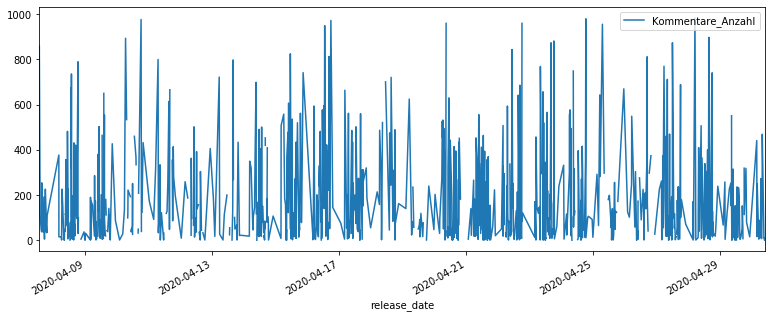

In [293]:
zeit_online["release_date"] = pd.to_datetime(zeit_online["release_date"])
scatter = zeit_online.plot(x="release_date",y="Kommentare_Anzahl", figsize=(13,5))
scatter